In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae,surv_gan,surv_vae
#from utils.metrics import log_rank, cox_estimation


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
n_samples = 600
n_features_bytype = 4
n_features_multiplier = 3 

In [3]:
beta_features = np.concatenate([weights_sparse_exp(n_features_bytype,3),weights_sparse_exp(n_features_bytype,3),
                       weights_sparse_exp(n_features_bytype,3)])
treatment_effect = 0

In [4]:
control, treated, types = simulation(beta_features, treatment_effect , n_samples , independent = False, surv_type = 'surv_weibull', n_features_bytype = 4, 
                n_features_multiplier = 3, nnz = 3 , p_treated = 0.5,a_T=2,
                a_C = 2., lamb_C = 6., lamb_C_indpt = 2.5, data_types_create = True)
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [5]:
print(np.mean(control['censor']),np.mean(treated['censor']))

0.8606811145510835 0.8628158844765343


In [6]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

In [7]:
control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Compute expected power / level via Schoenfeld formula

$$D = \frac{(\Phi^{-1}(\beta)+\Phi^{-1}(1-\alpha))^2}{P_{cont}(1 - P_{cont}) log^2(\Delta)}$$
where 
- $D$ is the number of deaths
- $\alpha$ is the level
- $\beta$ is the power
- $P_{cont}$ is the proportion of patients in the control arm
- $\Delta$ is the hazard ratio

D

In [8]:
D = np.sum(control['censor'])+np.sum(treated['censor'])
print(D)

517


In [9]:
alpha = 0.05
p_treated = treated.shape[0]/(control.shape[0]+treated.shape[0])
treatment_effect = 0.2
expected_power = norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha))

In [10]:
expected_power

np.float64(0.6206191223976134)

## Generation

In [11]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [12]:
data_init_control_encoded

tensor([[ 0.1593,  0.3693,  0.5103,  ...,  0.0000,  1.3611,  0.0000],
        [-0.5321, -1.2464, -1.6574,  ...,  1.0000,  0.6238,  1.0000],
        [-0.0407, -0.8763, -0.5367,  ...,  1.0000,  1.5375,  1.0000],
        ...,
        [ 1.4327,  1.5732,  1.3753,  ...,  0.0000,  3.8799,  1.0000],
        [-1.1395, -0.1851, -1.3472,  ...,  1.0000,  1.1084,  1.0000],
        [ 1.8968,  0.2319,  0.2151,  ...,  0.0000,  6.2644,  1.0000]])

In [13]:
data_init_control_encoded.shape

torch.Size([323, 18])

In [14]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [15]:
feat_types_dict

[{'': '0', 'name': 'feat1', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '1', 'name': 'feat2', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '2', 'name': 'feat3', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '3', 'name': 'feat4', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '4', 'name': 'feat5', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '5', 'name': 'feat6', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '6', 'name': 'feat7', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '7', 'name': 'feat8', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '8', 'name': 'feat9', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '9', 'name': 'feat10', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '10', 'name': 'feat11', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '11', 'name': 'feat12', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '12',
  'name': 'survcens',
  'type': 'surv_weibull',
  'dim': '2',
  'nclass': ''}]

In [16]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

In [17]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
#visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [18]:
names_cont = []
names_pos = []
names_cat = []
for x in range(1, n_features_bytype   + 1):
            names_pos.append("feat{0}".format(x + n_features_bytype))
            names_cat.append("feat{0}".format(x + 2 * n_features_bytype))

table1 = TableOne(df_init, categorical=names_cat, continuous=names_cont, 
                  groupby='treatment', nonnormal=names_pos, pval=True)
print(table1)

                          Grouped by treatment                                                     
                                       Missing        Overall              0              1 P-Value
n                                                         600            323            277        
feat1, mean (SD)                             0      0.0 (1.0)     -0.0 (1.0)      0.1 (1.0)   0.214
feat2, mean (SD)                             0      0.0 (0.9)      0.0 (0.9)     -0.0 (0.9)   0.756
feat3, mean (SD)                             0     -0.0 (1.0)     -0.0 (1.0)     -0.0 (0.9)   0.955
feat4, mean (SD)                             0      0.0 (1.0)     -0.0 (1.0)      0.0 (0.9)   0.767
feat5, median [Q1,Q3]                        0  0.7 [0.3,1.1]  0.7 [0.3,1.1]  0.7 [0.3,1.2]   0.964
feat6, median [Q1,Q3]                        0  0.7 [0.3,1.2]  0.7 [0.3,1.2]  0.6 [0.3,1.1]   0.935
feat7, median [Q1,Q3]                        0  0.7 [0.3,1.1]  0.7 [0.3,1.1]  0.7 [0.3,1.2]   0.801


In [19]:
# the datasets used for training is data_init_control
n_generated_dataset = 10
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [20]:
check = False
if check:
    data_gen_control_hivae = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
    data_gen_control_survgan = surv_gan.run(data_init_control, columns=fnames, target_column="censor", 
                                            time_to_event_column="time", n_generated_sample=n_generated_dataset)
    data_gen_control_survvae = surv_vae.run(data_init_control, columns=fnames, target_column="censor", 
                                            time_to_event_column="time", n_generated_sample=n_generated_dataset)
    df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=fnames)
    df_init_control_ext['sample'] = 1
    
    sel_idx = 0
    df_gen_control_ext_sel = pd.DataFrame(data_gen_control_hivae[sel_idx].numpy(), columns=fnames)
    df_gen_control_ext_sel['sample'] = 0
    
    # Save original values before overwriting
    #tmp = df_gen_control_ext_sel[['time', 'censor']].copy()
    
    # Replace 'time' with row-wise minimum
    #df_gen_control_ext_sel['time'] = tmp.min(axis=1)
    
    # Replace 'censor' with column name of the minimum ('time' or 'censor')
    #df_gen_control_ext_sel['censor'] = 1* (tmp.idxmin(axis=1)=='time')
    
    
    feat_types_dict_ext = feat_types_dict.copy()
    feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
    df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
    #visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [21]:
intervals

[(0.0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0), (1.0, 1.25)]

## Replication

In [22]:
n_generated_dataset = 20
dataset_name = "Simulations"

In [23]:
alphas = np.arange(0,0.3,0.2)
print(alphas)

[0.  0.2]


In [24]:
M = 50
log_p_value = []
log_p_value_gen_hivae = []
log_p_value_aug_hivae = []
log_p_value_gen_survgan = []
log_p_value_aug_survgan = []
log_p_value_gen_survvae = []
log_p_value_aug_survvae = []
p_treated_init = []
p_treated_eff= []

simu_num = []
treat_coef = []
D_init = []
D_eff_hivae = []
D_eff_survgan = []
D_eff_survvae = []
for t in alphas:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated, types = simulation(beta_features, treatment_effect , n_samples, independent = True, surv_type = 'surv_weibull')
        n_control_init = control.shape[0]
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')

        p_treated_init.append( treated.shape[0]/(control.shape[0]+treated.shape[0]))
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                     feat_types_file_control, 
                                                                                                                     miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
        
        # Load and transform treated data
        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                 miss_file, true_miss_file)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
    
        # Generate synthetic data
        data_gen_control_hivae = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
        
        data_gen_control_survgan = surv_gan.run(data_init_control, columns=fnames, target_column="censor", 
                                        time_to_event_column="time", n_generated_sample=n_generated_dataset)
    
        
        data_gen_control_survvae = surv_vae.run(data_init_control, columns=fnames, target_column="censor", 
                                        time_to_event_column="time", n_generated_sample=n_generated_dataset)

        # compute log-rank pvalues
        for i in range(n_generated_dataset):
            log_p_value.append(p_value_init)
            simu_num.append(m)
            D_init.append(control['censor'].sum()+treated['censor'].sum())

            ### HIVAE ###
            # Save original values before overwriting
            df_gen_control_ext_sel = pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)
            
            df_gen_control_hivae = pd.DataFrame(df_gen_control_ext_sel.to_numpy(), columns=fnames)
            #df_gen_control_hivae['treatment'] = 0
                     
            
            df_gen_control_aug_hivae = pd.DataFrame(torch.cat([data_init_control, torch.tensor(df_gen_control_ext_sel.to_numpy())]).numpy(), columns=fnames)
            #df_gen_control_aug_hivae['treatment'] = 0
            
            p_treated_eff.append( treated.shape[0]/(df_gen_control_aug_hivae.shape[0]+treated.shape[0]))
            
            D_eff_hivae.append(df_gen_control_aug_hivae['censor'].sum()+treated['censor'].sum())
            
            p_value_gen_hivae = compute_logrank_test(df_gen_control_hivae, treated)
            log_p_value_gen_hivae.append(p_value_gen_hivae)
            
            p_value_aug_hivae = compute_logrank_test(df_gen_control_aug_hivae, treated)
            log_p_value_aug_hivae.append(p_value_aug_hivae)

            ### SURVGAN ###
                        
            df_gen_control_survgan = pd.DataFrame(data_gen_control_survgan[i].numpy(), columns=fnames)
            #df_gen_control_survgan['treatment'] = 0
            
            df_gen_control_aug_survgan = pd.DataFrame(torch.cat([data_init_control, 
                                                                 torch.tensor(data_gen_control_survgan[i].numpy())]).numpy(), columns=fnames)
    
            #df_gen_control_aug_survgan['treatment'] = 0


            
            D_eff_survgan.append(df_gen_control_aug_survgan['censor'].sum()+treated['censor'].sum())
            
            p_value_gen_survgan = compute_logrank_test(df_gen_control_survgan, treated)
            log_p_value_gen_survgan.append(p_value_gen_survgan)

            p_value_aug_survgan = compute_logrank_test(df_gen_control_aug_survgan, treated)
            log_p_value_aug_survgan.append(p_value_aug_survgan)

            ### SURVVAE ###

            df_gen_control_survvae = pd.DataFrame(data_gen_control_survvae[i].numpy(), columns=fnames)
            #df_gen_control_survvae['treatment'] = 0
            
            df_gen_control_aug_survvae = pd.DataFrame(torch.cat([data_init_control, 
                                                                 torch.tensor(data_gen_control_survvae[i].numpy())]).numpy(), columns=fnames)
    
            #df_gen_control_aug_survvae['treatment'] = 0


            
            D_eff_survvae.append(df_gen_control_aug_survvae['censor'].sum()+treated['censor'].sum())
            
            p_value_gen_survvae = compute_logrank_test(df_gen_control_survvae, treated)
            log_p_value_gen_survvae.append(p_value_gen_survvae)

            p_value_aug_survvae = compute_logrank_test(df_gen_control_aug_survvae, treated)
            log_p_value_aug_survvae.append(p_value_aug_survvae)
            
            
            treat_coef.append(treatment_effect)
            

0


[2025-05-23T12:28:32.360948+0200][39143][CRITICAL] Error importing TabularGoggle: No module named 'dgl'
[2025-05-23T12:28:32.362611+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T12:28:33.479013+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|██████▌                                                        | 1049/10000 [00:31<04:28, 33.28it/s]
[2025-05-23T12:29:06.561507+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T12:29:06.574994+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 60%|█████████████████████████

10


[2025-05-23T12:39:48.927182+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T12:39:49.002294+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████                                                           | 799/10000 [00:31<06:08, 24.98it/s]
[2025-05-23T12:40:23.374046+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T12:40:23.396561+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:28<00:34, 15.83it/s]
[2025-05-23T12:41:05.789376+

20


[2025-05-23T12:52:21.889762+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T12:52:21.960749+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|██████▍                                                         | 999/10000 [00:38<05:44, 26.11it/s]
[2025-05-23T12:53:02.235993+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T12:53:02.254857+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:17<00:32, 20.25it/s]
[2025-05-23T12:53:30.595122+

30


[2025-05-23T13:04:38.961463+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:04:39.030384+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▊                                                           | 749/10000 [00:29<06:06, 25.25it/s]
[2025-05-23T13:05:10.766381+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:05:10.782688+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:22<00:28, 19.58it/s]
[2025-05-23T13:05:45.522137+

40


[2025-05-23T13:17:11.486356+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:17:11.566224+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▌                                                             | 399/10000 [00:15<06:12, 25.74it/s]
[2025-05-23T13:17:29.194604+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:17:29.211765+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 60%|███████████████████████████████████████                          | 600/1000 [00:30<00:20, 19.37it/s]
[2025-05-23T13:18:12.643961+

0


[2025-05-23T13:28:35.707393+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:28:35.777123+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 12%|███████▌                                                       | 1199/10000 [00:44<05:30, 26.66it/s]
[2025-05-23T13:29:22.761486+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:29:22.779419+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 55%|███████████████████████████████████▊                             | 550/1000 [00:26<00:21, 20.69it/s]
[2025-05-23T13:30:00.412574+

10


[2025-05-23T13:45:39.634855+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:45:39.696804+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▊                                                           | 749/10000 [00:26<05:25, 28.41it/s]
[2025-05-23T13:46:08.177256+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:46:08.191871+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:18<00:27, 22.19it/s]
[2025-05-23T13:46:36.640906+

20


[2025-05-23T13:56:20.153872+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:56:20.225561+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  3%|██▏                                                             | 349/10000 [00:11<05:22, 29.91it/s]
[2025-05-23T13:56:34.311888+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T13:56:34.327982+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:22<00:28, 19.60it/s]
[2025-05-23T13:57:08.565322+

30


[2025-05-23T14:06:50.595960+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T14:06:50.652221+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▌                                                             | 399/10000 [00:13<05:12, 30.68it/s]
[2025-05-23T14:07:05.897015+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T14:07:05.913713+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 65%|██████████████████████████████████████████▎                      | 650/1000 [00:35<00:18, 18.46it/s]
[2025-05-23T14:07:52.681447+

40


[2025-05-23T14:18:31.273859+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T14:18:31.327219+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|█████▊                                                          | 899/10000 [00:32<05:28, 27.67it/s]
[2025-05-23T14:19:05.917729+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T14:19:05.938322+0200][39143][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:23<00:28, 19.20it/s]
[2025-05-23T14:19:40.888392+

In [28]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value,  "treat_coef" : treat_coef, "D_init" : D_init,
                        "log_pvalue_gen_hivae" : log_p_value_gen_hivae ,
                        "log_pvalue_aug_hivae" : log_p_value_aug_hivae , "D_eff_hivae" : D_eff_hivae,
                       "log_pvalue_gen_survgan" : log_p_value_gen_survgan ,
                        "log_pvalue_aug_survgan" : log_p_value_aug_survgan , "D_eff_survgan" : D_eff_survgan,
                        "log_pvalue_gen_survvae" : log_p_value_gen_survvae ,
                        "log_pvalue_aug_survvae" : log_p_value_aug_survvae , "D_eff_survvae" : D_eff_survvae})#,
                        #"p_treated_init" : p_treated_init,"p_treated_eff" : p_treated_eff})
                       
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen_hivae"] = results['log_pvalue_gen_hivae'] > -np.log(0.05)
results["reject_H0_aug_hivae"] = results['log_pvalue_aug_hivae'] > -np.log(0.05)

results["reject_H0_gen_survgan"] = results['log_pvalue_gen_survgan'] > -np.log(0.05)
results["reject_H0_aug_survgan"] = results['log_pvalue_aug_survgan'] > -np.log(0.05)


results["reject_H0_gen_survvae"] = results['log_pvalue_gen_survvae'] > -np.log(0.05)
results["reject_H0_aug_survvae"] = results['log_pvalue_aug_survvae'] > -np.log(0.05)


In [29]:
results

,XP_num,log_pvalue_init,treat_coef,D_init,log_pvalue_gen_hivae,log_pvalue_aug_hivae,D_eff_hivae,log_pvalue_gen_survgan,log_pvalue_aug_survgan,D_eff_survgan,log_pvalue_gen_survvae,log_pvalue_aug_survvae,D_eff_survvae,reject_H0_init,reject_H0_gen_hivae,reject_H0_aug_hivae,reject_H0_gen_survgan,reject_H0_aug_survgan,reject_H0_gen_survvae,reject_H0_aug_survvae
0,0,0.176157,0.0,514,11.881733,5.372439,754.0,18.304055,4.836154,767.0,8.631168,2.475316,787.0,False,True,True,True,True,True,False
1,0,0.176157,0.0,514,10.205134,4.798220,770.0,19.887100,5.266422,768.0,3.946661,1.189663,773.0,False,True,True,True,True,True,False
2,0,0.176157,0.0,514,12.120378,5.509051,763.0,14.413539,4.007274,765.0,5.718327,1.691428,776.0,False,True,True,True,True,True,False
3,0,0.176157,0.0,514,17.750288,7.852219,767.0,12.546398,3.528037,764.0,5.626690,1.612925,771.0,False,True,True,True,True,True,False
4,0,0.176157,0.0,514,10.144303,4.714270,769.0,17.129624,4.460151,765.0,4.669936,1.406322,772.0,False,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,49,5.704586,0.2,514,13.039855,11.903228,751.0,1.591507,4.697044,757.0,7.743892,0.317272,790.0,True,True,True,False,True,True,False
1996,49,5.704586,0.2,514,11.873375,11.306678,754.0,1.250829,4.358052,754.0,3.662052,0.929297,783.0,True,True,True,False,True,True,False
1997,49,5.704586,0.2,514,12.325065,11.648332,755.0,1.287348,4.324592,762.0,5.513952,0.626249,781.0,True,True,True,False,True,True,False
1998,49,5.704586,0.2,514,13.015071,11.892124,743.0,0.627916,3.655846,758.0,3.781463,0.918446,789.0,True,True,True,False,True,True,False


In [38]:
results.groupby("treat_coef").mean()

,XP_num,log_pvalue_init,D_init,log_pvalue_gen_hivae,log_pvalue_aug_hivae,D_eff_hivae,log_pvalue_gen_survgan,log_pvalue_aug_survgan,D_eff_survgan,log_pvalue_gen_survvae,log_pvalue_aug_survvae,D_eff_survvae,reject_H0_init,reject_H0_gen_hivae,reject_H0_aug_hivae,reject_H0_gen_survgan,reject_H0_aug_survgan,reject_H0_gen_survvae,reject_H0_aug_survvae
treat_coef,,,,,,,,,,,,,,,,,,,
0.0,24.5,0.943434,513.12,4.084784,2.250322,760.481,6.378198,2.607151,768.004,9.268578,3.421407,783.359,0.04,0.434,0.234,0.518,0.357,0.813,0.431
0.2,24.5,1.893668,514.58,6.222529,4.602465,763.027,4.313331,2.084976,769.890,5.487831,1.676368,786.373,0.20,0.674,0.613,0.383,0.267,0.565,0.186


In [30]:
#results.to_csv("./dataset/" + dataset_name + "/results_aug_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [31]:
alpha = 0.05
p_treated = 0.5
D_means_init = results.groupby("treat_coef").mean()["D_init"].to_numpy()
D_means_eff = results.groupby("treat_coef").mean()["D_eff_hivae"].to_numpy()
p_treated_init = results.groupby("treat_coef").mean()["p_treated_init"].to_numpy()
p_treated_eff = results.groupby("treat_coef").mean()["p_treated_eff"].to_numpy()
expected_power_init = []
expected_power_eff = []
for i in np.arange(alphas.shape[0]):
    treat_E = alphas[i]
    D = D_means_init[i]
    expected_power_init.append(norm.cdf(np.sqrt( D * p_treated_init[i] * (1 - p_treated_init[i]) * (treat_E)**2 ) - norm.ppf(1 - alpha)))
    D = D_means_eff[i]
    expected_power_eff.append(norm.cdf(np.sqrt( D * p_treated_eff[i] * (1 - p_treated_eff[i]) * (treat_E)**2 ) - norm.ppf(1 - alpha)))

KeyError: 'p_treated_init'

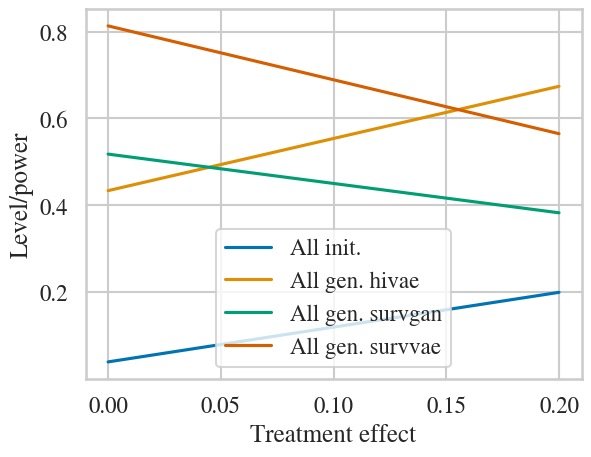

In [37]:
puiss_init = results.groupby("treat_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen_hivae = results.groupby("treat_coef").mean()["reject_H0_gen_hivae"].to_numpy()
puiss_aug_hivae = results.groupby("treat_coef").mean()["reject_H0_aug_hivae"].to_numpy()
puiss_gen_survgan = results.groupby("treat_coef").mean()["reject_H0_gen_survgan"].to_numpy()
puiss_aug_survgan = results.groupby("treat_coef").mean()["reject_H0_aug_survgan"].to_numpy()
puiss_gen_survvae = results.groupby("treat_coef").mean()["reject_H0_gen_survvae"].to_numpy()
puiss_aug_survvae = results.groupby("treat_coef").mean()["reject_H0_aug_survvae"].to_numpy()


#puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.plot(alphas,puiss_init,label = "All init.")
plt.plot(alphas,puiss_gen_hivae,label = "All gen. hivae")
#plt.scatter(alphas,puiss_aug_hivae,label = "All aug. hivae")

plt.plot(alphas,puiss_gen_survgan,label = "All gen. survgan")
#plt.scatter(alphas,puiss_aug_survgan,label = "All aug. survgan")

plt.plot(alphas,puiss_gen_survvae,label = "All gen. survvae")
#plt.scatter(alphas,puiss_aug_survvae,label = "All aug. survvae")

#plt.scatter(alphas,puiss_among_reject,label = "Gen. from reject")
#plt.scatter(alphas,puiss_among_accept,label = "Gen. from accept")
#plt.plot(alphas,expected_power_init, label = "Exp. power init")
#plt.plot(alphas,expected_power_eff, label = "Exp. power eff")

plt.legend()
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

In [38]:
df_gen_control_ext_sel = pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)
            
df_gen_control_hivae = pd.DataFrame(df_gen_control_ext_sel.to_numpy(), columns=fnames)
                     
df_gen_control_aug_hivae = pd.DataFrame(torch.cat([data_init_control, torch.tensor(df_gen_control_ext_sel.to_numpy())]).numpy(), columns=fnames)


In [34]:
compute_logrank_test(df_gen_control_aug_hivae, treated)

np.float64(1.0435361469713111)

In [35]:
df_gen_control_hivae

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,time,censor
0,0.730041,0.987681,0.642334,1.453793,1.917820,1.739128,1.687435,1.680922,1.0,1.0,0.0,0.0,4.628183,0.0
1,-1.026432,0.559411,-1.777656,-0.939306,1.447164,3.807603,2.507634,2.162721,0.0,0.0,1.0,1.0,0.574775,1.0
2,0.748662,-0.140380,-0.049446,-1.361672,1.464559,1.981424,1.532095,2.014337,1.0,0.0,1.0,0.0,1.428925,1.0
3,1.401806,0.399560,-1.387981,-1.035156,1.323153,1.433530,1.069537,2.799398,1.0,1.0,1.0,1.0,2.091294,1.0
4,-0.425656,0.288912,-0.214142,1.351700,1.948845,1.893928,2.093151,1.549557,0.0,0.0,0.0,0.0,0.172579,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0.777515,0.355262,1.337751,1.190124,1.701314,1.037827,1.261139,1.965412,0.0,0.0,0.0,1.0,2.004250,1.0
310,-1.383701,-0.162010,-2.155475,-0.300026,2.119823,1.264601,1.327219,1.536416,0.0,0.0,1.0,1.0,5.300308,1.0
311,0.294744,1.238728,2.117120,0.937027,1.792328,1.859913,1.657357,1.687260,1.0,0.0,1.0,0.0,3.140888,1.0
312,-1.594423,-0.576805,-0.975873,-0.294086,1.560031,1.442574,1.446795,1.439615,0.0,1.0,0.0,0.0,1.395091,1.0


In [36]:
pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,time,censor
0,0.730041,0.987681,0.642334,1.453793,1.917820,1.739128,1.687435,1.680922,1.0,1.0,0.0,0.0,4.628183,0.0
1,-1.026432,0.559411,-1.777656,-0.939306,1.447164,3.807603,2.507634,2.162721,0.0,0.0,1.0,1.0,0.574775,1.0
2,0.748662,-0.140380,-0.049446,-1.361672,1.464559,1.981424,1.532095,2.014337,1.0,0.0,1.0,0.0,1.428925,1.0
3,1.401806,0.399560,-1.387981,-1.035156,1.323153,1.433530,1.069537,2.799398,1.0,1.0,1.0,1.0,2.091294,1.0
4,-0.425656,0.288912,-0.214142,1.351700,1.948845,1.893928,2.093151,1.549557,0.0,0.0,0.0,0.0,0.172579,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0.777515,0.355262,1.337751,1.190124,1.701314,1.037827,1.261139,1.965412,0.0,0.0,0.0,1.0,2.004250,1.0
310,-1.383701,-0.162010,-2.155475,-0.300026,2.119823,1.264601,1.327219,1.536416,0.0,0.0,1.0,1.0,5.300308,1.0
311,0.294744,1.238728,2.117120,0.937027,1.792328,1.859913,1.657357,1.687260,1.0,0.0,1.0,0.0,3.140888,1.0
312,-1.594423,-0.576805,-0.975873,-0.294086,1.560031,1.442574,1.446795,1.439615,0.0,1.0,0.0,0.0,1.395091,1.0


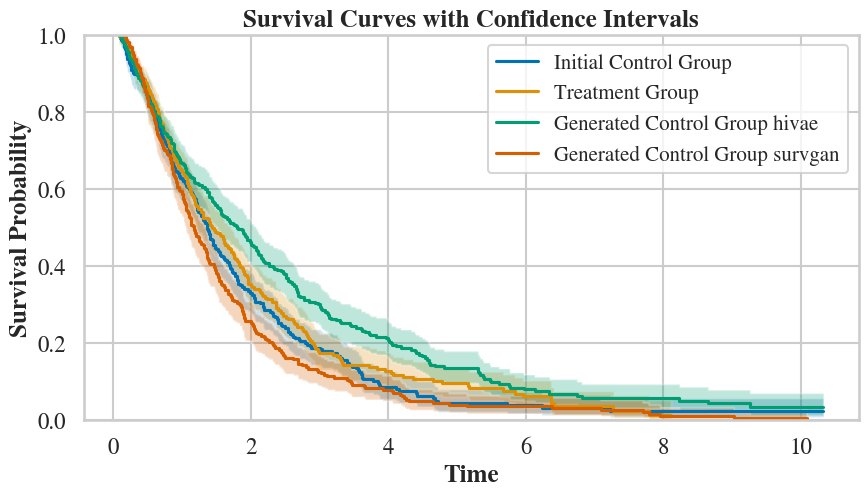

In [37]:
surv_time_control_init  = control['time'].values
surv_ind_control_init = control['censor'].values.astype(bool)

surv_time_treated_init = treated['time'].values
surv_ind_treated_init = treated['censor'].values.astype(bool)

df_syn_sel = pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)
surv_time_control_gen = df_syn_sel['time'].values
surv_ind_control_gen = df_syn_sel['censor'].values.astype(bool)

df_syn_sel2 = pd.DataFrame(data_gen_control_survgan[i].numpy(), columns=fnames)
surv_time_control_gen2 = df_syn_sel2['time'].values
surv_ind_control_gen2 = df_syn_sel2['censor'].values.astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")
uniq_time_control_gen2, surv_prob_control_gen2, conf_int_control_gen2 = kaplan_meier_estimator(surv_ind_control_gen2, surv_time_control_gen2, conf_type="log-log")


plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group hivae")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")


plt.step(uniq_time_control_gen2, surv_prob_control_gen2, where="post", label="Generated Control Group survgan")
plt.fill_between(uniq_time_control_gen2, conf_int_control_gen2[0], conf_int_control_gen2[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [47]:
results

,XP_num,log_pvalue_init,treat_coef,D_init,log_pvalue_gen_hivae,log_pvalue_aug_hivae,D_eff_hivae,reject_H0_init,reject_H0_gen_hivae,reject_H0_aug_hivae
0,0,0.186893,0.0,508,0.035039,0.150115,792.0,False,False,False
1,0,0.186893,0.0,508,0.309929,0.059052,782.0,False,False,False
2,0,0.186893,0.0,508,0.233141,0.239920,793.0,False,False,False
3,0,0.186893,0.0,508,0.982227,0.349177,783.0,False,False,False
4,0,0.186893,0.0,508,0.943747,0.325284,785.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...
395,9,3.058809,0.5,523,6.483205,6.004183,783.0,True,True,True
396,9,3.058809,0.5,523,6.810208,6.220215,781.0,True,True,True
397,9,3.058809,0.5,523,7.511737,6.658681,776.0,True,True,True
398,9,3.058809,0.5,523,11.864071,8.962230,767.0,True,True,True


In [52]:
print(expected_power_init,expected_power_eff)

[np.float64(0.024999999999999998), np.float64(0.999914507682007)] [np.float64(0.024999999999999998), np.float64(0.9999996690643097)]


array([514., 509.])

array([514., 509.])

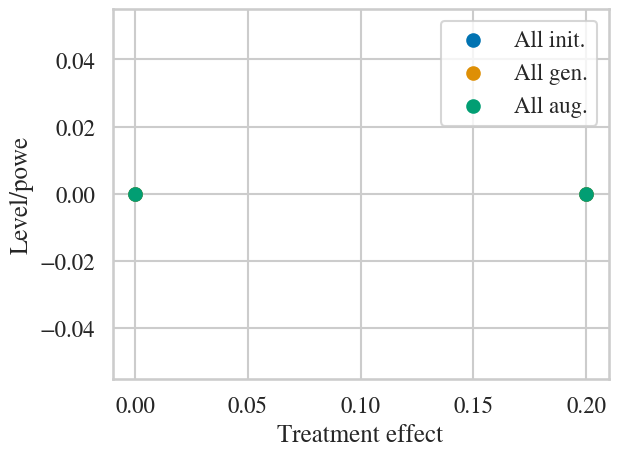

In [43]:
puiss_init = results.groupby("treat_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen = results.groupby("treat_coef").mean()["reject_H0_gen"].to_numpy()
puiss_aug = results.groupby("treat_coef").mean()["reject_H0_aug"].to_numpy()
#puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.scatter(alphas,puiss_init,label = "All init.")
plt.scatter(alphas,puiss_gen,label = "All gen.")
plt.scatter(alphas,puiss_aug,label = "All aug.")
#plt.scatter(alphas,puiss_among_reject,label = "Gen. from reject")
#plt.scatter(alphas,puiss_among_accept,label = "Gen. from accept")
#plt.plot(alphas,expected_power,label = "Expected level/power")
#plt.plot(np.arange(alphas.min(),alphas.max() + 0.01,0.01),expected_power,label = "Expected level/power")
plt.legend()
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

## TODO point size should be proportional to sample size

#### Subsampling

In [ ]:
M = 100
log_p_value = []
log_p_value_gen = []
log_p_value_aug = []
simu_num = []
treat_coef = []
p_choices = np.arange(0.2,0.6,0.2) 
D_init = []
D_eff = []
for t in alphas:
    treatment_effect = t
    for p in p_choices:
        for m in np.arange(M):
            if m % 10 == 0:
                print(m)
            control, treated, types = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull")
            control = control.sample(frac=1-p, replace=False)
            control = control.drop(columns='treatment')
            treated = treated.drop(columns='treatment')
    
            D =  n_samples - np.sum(control['censor']) - np.sum(treated['censor'])
            D_init.append(D)
            
            data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
            data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
            
            
            control.to_csv(data_file_control,index=False , header=False)
            treated.to_csv(data_file_treated,index=False , header=False)
            
            df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
            df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
            
            T_surv = torch.Tensor(df_init_control.time)
            T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
            n_intervals = 5
            T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
            T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
            intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
            
            p_value_init = compute_logrank_test(control, treated)
        
            
        
            # Load and transform control data
            data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                         feat_types_file_control, 
                                                                                                                         miss_file, true_miss_file)
            data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
            
            # Load and transform treated data
            data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                     miss_file, true_miss_file)
            data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
        
            data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                          true_miss_mask_control, feat_types_file_control, feat_types_dict, 
                                            n_generated_dataset, verbose=False)
            
            for i in range(n_generated_dataset):
                D_init.append(control['censor'].sum()+treated['censor'].sum())
        
                
                df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
                df_gen_control = df_gen_control.sample(frac=p, replace=False)
                df_gen_control['treatment'] = 0
                
                df_gen_control_aug = pd.DataFrame(torch.cat([data_init_control, data_gen_control[i]]).numpy(), columns=fnames)
                df_gen_control_aug['treatment'] = 0
                log_p_value.append(p_value_init)
                simu_num.append(m)
                
                D_eff.append(df_gen_control_aug['censor'].sum()+treated['censor'].sum())
                
                p_value_gen = compute_logrank_test(df_gen_control, treated)
                log_p_value_gen.append(p_value_gen)
    
                p_value_aug = compute_logrank_test(df_gen_control_aug, treated)
                log_p_value_aug.append(p_value_aug)
                
                treat_coef.append(treatment_effect)

                 

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0


In [ ]:
results.to_csv("./dataset/" + dataset_name + "/results_sub_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")